<a href="https://colab.research.google.com/github/jc020230/gc4-sand/blob/main/1028%202%20baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Baseline 모형 제작

In [ ]:
!pip install openpyxl

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/SAND_Challenge_task1_dataset/task1/sand_task_1.xlsx'


try:
    df_all = pd.read_excel(file_path, sheet_name='SAND - TRAINING set - Task 1')

    df_trn = pd.read_excel(file_path, sheet_name='Training Baseline - Task 1')

    df_val = pd.read_excel(file_path, sheet_name='Validation Baseline - Task 1')

    print("파일 읽기 성공!")
    print(df_all.head())

except FileNotFoundError:
    print(f"오류: 파일을 찾을 수 없습니다.")
    print(f"경로를 다시 확인해주세요: {file_path}")
except Exception as e:
    print(f"파일을 읽는 중 오류가 발생했습니다: {e}")

파일 읽기 성공!
      ID  Age Sex  Class
0  ID000   80   M      5
1  ID001   61   F      5
2  ID002   51   F      4
3  ID003   59   M      3
4  ID005   80   F      5


In [ ]:
trn_ids = df_trn['ID'].tolist()
val_ids = df_val['ID'].tolist()
len(trn_ids), len(val_ids)

(219, 53)

In [ ]:
trn_folder = '/content/drive/MyDrive/SAND_Challenge_task1_dataset/task1/training'

import os
import glob
import re
from pathlib import Path

# training 폴더의 모든 wav 파일 찾기
wav_files = []
wav_info_dict = {}
wav_files_trn = []
wav_files_val = []

# rhythmPA와 rhythmTA 폴더에서 wav 파일 찾기
for subfolder in ['phonationA', 'phonationE','phonationI', 'phonationO', 'phonationU','rhythmKA','rhythmPA', 'rhythmTA']:
    folder_path = os.path.join(trn_folder, subfolder)
    if os.path.exists(folder_path):
        # glob을 사용하여 wav 파일 찾기
        pattern = os.path.join(folder_path, '*.wav')
        files = glob.glob(pattern)
        wav_files.extend(files)

print(f"총 {len(wav_files)}개의 wav 파일을 찾았습니다.")

# 파일 경로에서 ID 추출하고 라벨 정보 매칭
for file_path in wav_files:
    # 파일명에서 ID 추출 (IDxxx 형태)
    filename = os.path.basename(file_path)
    id_match = re.search(r'(ID\d+)', filename)

    if id_match:
        id_num = id_match.group(1)  # ID 번호를 정수로 변환

        # 트레인/밸리데이션 데이터셋에 따라 파일 경로 분류
        if id_num in trn_ids:
            wav_files_trn.append(file_path)
        elif id_num in val_ids:
            wav_files_val.append(file_path)

        # df_all에서 해당 ID의 정보 찾기
        matching_row = df_all[df_all['ID'] == id_num]

        ## task_type 정보 추가
        if not matching_row.empty:
            # 라벨 정보 추출
            label_info = {
                'file_path': file_path,
                'id': id_num,
                'class': matching_row['Class'].values[0],
                'age': matching_row['Age'].values[0],
                'sex': matching_row['Sex'].values[0]
            }
            wav_info_dict[file_path] = label_info
        else:
            print(f"Warning: ID {id_num}에 대한 라벨 정보를 찾을 수 없습니다. 파일: {filename}")
    else:
        print(f"Warning: 파일명에서 ID를 추출할 수 없습니다: {filename}")

print(f"\n라벨 정보가 매칭된 파일: {len(wav_info_dict)}개")



총 2176개의 wav 파일을 찾았습니다.

라벨 정보가 매칭된 파일: 2176개


In [ ]:
len(wav_files), len(wav_files_trn), len(wav_files_val)

(2176, 1752, 424)

In [ ]:
wav_info_dict[wav_files[0]]  # 예시로 첫 번째 파일의 라벨 정보 출력

{'file_path': '/content/drive/MyDrive/SAND_Challenge_task1_dataset/task1/training/phonationA/ID088_phonationA.wav',
 'id': 'ID088',
 'class': np.int64(2),
 'age': np.int64(55),
 'sex': 'F'}

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

!pip install -q audiomentations
import audiomentations as A
from sklearn.metrics import f1_score
from torch.utils.data import WeightedRandomSampler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 21.4 MB/s eta 0:00:00


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from torch.utils.data import Dataset
import numpy as np
from scipy.signal import resample_poly
import torchaudio.transforms as T
import torch.nn.functional as F
import librosa # torchaudio ->librosa로 로드 (audiomentations 호환)

n_fft = 512      # 약 64ms window
hop_length = 256  # 50% overlap
n_mels = 80      # 보통 60~ 120 정도 사용

class SANDDataset(Dataset):
    def __init__(
        self,
        file_list=None,
        labels = None,
        sr=8000,
        samp_sec=10,
        is_train=False
    ):
        self.sr = sr
        self.samp_sec = samp_sec
        self.seq_length = int(sr * samp_sec)
        self.labels = labels
        self.files = file_list
        self.is_train = is_train

        if self.is_train:
            # 1. 오디오 파형 증강
            self.audio_augment_pipeline = A.Compose([
                A.SomeOf(
                    transforms=[
                        A.TimeStretch(min_rate=0.9, max_rate=1.1, p=0.5),
                        A.PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
                        A.AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.008, p=0.5),
                    ],
                    num_transforms=(1, 2), # Apply 1 to 2 transforms
                )
            ], p=0.8) # 80% 확률로 오디오 증강 적용

            # 2. 스펙트로그램 증강 (SpecAugment)
            self.spec_augment_pipeline = nn.Sequential(
                T.FrequencyMasking(freq_mask_param=30), # Mel 밴드 80개 중 최대 30개 마스킹
                T.TimeMasking(time_mask_param=40),      # Time 스텝 313개 중 최대 40개 마스킹
            )



    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        label = self.labels[file_path]['class'] - 1  # 0부터 시작하도록 조정

        try:
            waveform, original_sr = librosa.load(file_path, sr=self.sr, mono=True)
            waveform = torch.from_numpy(waveform).unsqueeze(0) # (1, T) 텐서로
        except Exception as e:
            # print(f"파일 로드 오류 {file_path}: {e}")
            waveform = torch.zeros(1, self.seq_length) # 오류 시 빈 텐서
            original_sr = self.sr

        if self.is_train and waveform.shape[1] > 0:
             waveform_np = self.audio_augment_pipeline(samples=waveform.numpy().squeeze(), sample_rate=self.sr)
             waveform = torch.from_numpy(waveform_np).unsqueeze(0)


        # Calculate target length in samples
        target_length = int(self.sr * self.samp_sec)  # e.g., 8000 * 10 = 80000 samples

        # Pad or trim waveform to target length
        current_length = waveform.shape[-1]
        if current_length < target_length:
            padding = target_length - current_length
            waveform = F.pad(waveform, (0, padding), mode='constant', value=0)
        elif current_length > target_length:
            waveform = waveform[:, :target_length]

        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        # MelSpectrogram -> (1, n_mels, time)
        mel = T.MelSpectrogram(
            sample_rate= self.sr,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels,
            win_length=n_fft,
            window_fn=torch.hann_window,
            power=2.0
        )(waveform) # (1, n_mels, time)

        # Log-compression with epsilon for numerical stability
        mel = torch.log(mel + 1e-6)

        # 훈련 시에만 스펙트로그램 증강 적용
        if self.is_train:
            mel = self.spec_augment_pipeline(mel)

        label_tensor = torch.tensor(label, dtype=torch.long)
        return mel, label_tensor

In [ ]:
wav_files_trn[:5]

['/content/drive/MyDrive/SAND_Challenge_task1_dataset/task1/training/phonationA/ID088_phonationA.wav',
 '/content/drive/MyDrive/SAND_Challenge_task1_dataset/task1/training/phonationA/ID006_phonationA.wav',
 '/content/drive/MyDrive/SAND_Challenge_task1_dataset/task1/training/phonationA/ID077_phonationA.wav',
 '/content/drive/MyDrive/SAND_Challenge_task1_dataset/task1/training/phonationA/ID013_phonationA.wav',
 '/content/drive/MyDrive/SAND_Challenge_task1_dataset/task1/training/phonationA/ID174_phonationA.wav']

In [ ]:
trn_dataset = SANDDataset(
    file_list=wav_files_trn,
    labels=wav_info_dict,
    sr=8000,
    samp_sec=10,
    is_train=True # 훈련용
)

val_dataset = SANDDataset(
    file_list=wav_files_val,
    labels=wav_info_dict,
    sr=8000,
    samp_sec=10,
    is_train=False # 검증용
)
# -----------------------------------

trn_dataset[0]

(tensor([[[-4.7909, -5.7674, -6.8383,  ..., -7.3135, -7.4998, -2.8851],
          [-5.7221, -5.9649, -5.7608,  ..., -8.1514, -8.1587, -2.7385],
          [-4.9959, -4.9964, -5.5344,  ..., -6.7697, -8.3476, -2.5762],
          ...,
          [-6.3148, -5.8279, -6.1435,  ...,  0.3748,  0.1015,  0.5629],
          [-5.3553, -5.7379, -5.0888,  ..., -1.7757, -1.0786, -1.3853],
          [-6.2246, -5.7627, -5.3640,  ..., -0.8614, -0.8199, -0.7006]]]),
 tensor(1))

In [ ]:
len(trn_dataset)

1752

In [ ]:
from torch.utils.data import DataLoader
import numpy as np

batch_size = 32

# 클래스 불균형 해소 -> WeightedRandomSampler

# 1. 훈련 데이터셋의 모든 레이블 가져오기
train_labels = [wav_info_dict[f]['class'] - 1 for f in wav_files_trn]

# 2. 클래스별 데이터 개수 세기
class_counts = np.bincount(train_labels)

# 3. 클래스별 가중치 계산 (역수)
class_weights = 1. / class_counts
sample_weights = np.array([class_weights[t] for t in train_labels])
sample_weights = torch.from_numpy(sample_weights).double()

# 4. Sampler 생성
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

# 5. 손실 함수에 사용할 가중치 (GPU로 이동 준비)
loss_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"클래스 카운트: {class_counts}")
print(f"손실 가중치: {loss_weights}")


trn_loader = DataLoader(
    trn_dataset,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)


print(f"Train loader: {len(trn_loader)} batches")
print(f"Val loader: {len(val_loader)} batches")

클래스 카운트: [ 32 176 360 496 688]
손실 가중치: tensor([0.0312, 0.0057, 0.0028, 0.0020, 0.0015], device='cuda:0')
Train loader: 55 batches
Val loader: 14 batches


In [ ]:
first_batch = next(iter(trn_loader))
mel_specs, labels1 = first_batch

print(f"첫 번째 배치 정보:")
print(f"Mel spectrogram 형태: {mel_specs.shape}")
print(f"Labels 형태: {labels1.shape}")
print(f"Labels 타입: {type(labels1)}")
print(f"첫 5개 라벨: {labels1[:5]}")

첫 번째 배치 정보:
Mel spectrogram 형태: torch.Size([32, 1, 80, 313])
Labels 형태: torch.Size([32])
Labels 타입: <class 'torch.Tensor'>
첫 5개 라벨: tensor([2, 4, 4, 2, 4])


In [ ]:
class LCNN(nn.Module):
    def __init__(self, input_shape=(1, 64, 128), n_output=2, dropout_rate=0.5):
        super(LCNN, self).__init__()

        self.dropout_rate = dropout_rate

        # Block 1: Conv 5x5 + MFM + MaxPool
        self.conv1_1 = nn.Conv2d(input_shape[0], 32, kernel_size=5, stride=1, padding=2)
        self.conv1_2 = nn.Conv2d(input_shape[0], 32, kernel_size=5, stride=1, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Block 2: Conv 1x1 + MFM + BatchNorm
        self.conv2_1 = nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0)
        self.conv2_2 = nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0)
        self.batch_norm2 = nn.BatchNorm2d(32, affine=False)

        # Block 3: Conv 3x3 + MFM + MaxPool + BatchNorm
        self.conv3_1 = nn.Conv2d(32, 48, kernel_size=3, stride=1, padding=1)
        self.conv3_2 = nn.Conv2d(32, 48, kernel_size=3, stride=1, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(48, affine=False)

        # Block 4: Conv 1x1 + MFM + BatchNorm
        self.conv4_1 = nn.Conv2d(48, 48, kernel_size=1, stride=1, padding=0)
        self.conv4_2 = nn.Conv2d(48, 48, kernel_size=1, stride=1, padding=0)
        self.batch_norm4 = nn.BatchNorm2d(48, affine=False)

        # Block 5: Conv 3x3 + MFM + MaxPool
        self.conv5_1 = nn.Conv2d(48, 64, kernel_size=3, stride=1, padding=1)
        self.conv5_2 = nn.Conv2d(48, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Block 6: Conv 1x1 + MFM + BatchNorm
        self.conv6_1 = nn.Conv2d(64, 64, kernel_size=1, stride=1, padding=0)
        self.conv6_2 = nn.Conv2d(64, 64, kernel_size=1, stride=1, padding=0)
        self.batch_norm6 = nn.BatchNorm2d(64, affine=False)

        # Block 7: Conv 3x3 + MFM + BatchNorm
        self.conv7_1 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.conv7_2 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.batch_norm7 = nn.BatchNorm2d(32, affine=False)

        # Block 8: Conv 3x3 + MFM + BatchNorm
        self.conv8_1 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv8_2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.batch_norm8 = nn.BatchNorm2d(32, affine=False)

        # Block 9: Conv 3x3 + MFM + MaxPool
        self.conv9_1 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv9_2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.maxpool9 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Global Average Pooling instead of flatten
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully Connected layers with MFM - fixed size now (32 channels after Block 9)
        self.fc1_1 = nn.Linear(32, 15)
        self.fc1_2 = nn.Linear(32, 15)
        self.batch_norm_fc = nn.BatchNorm1d(15, affine=False)

        # Dropout and final layer
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc_final = nn.Linear(15, n_output)

    def _forward_conv_layers(self, x):
        """Forward pass through convolutional layers only"""
        # Block 1
        conv1_1 = self.conv1_1(x)
        conv1_2 = self.conv1_2(x)
        mfm1 = torch.max(conv1_1, conv1_2)
        x = self.maxpool1(mfm1)

        # Block 2
        conv2_1 = self.conv2_1(x)
        conv2_2 = self.conv2_2(x)
        mfm2 = torch.max(conv2_1, conv2_2)
        x = self.batch_norm2(mfm2)

        # Block 3
        conv3_1 = self.conv3_1(x)
        conv3_2 = self.conv3_2(x)
        mfm3 = torch.max(conv3_1, conv3_2)
        x = self.maxpool3(mfm3)
        x = self.batch_norm3(x)

        # Block 4
        conv4_1 = self.conv4_1(x)
        conv4_2 = self.conv4_2(x)
        mfm4 = torch.max(conv4_1, conv4_2)
        x = self.batch_norm4(mfm4)

        # Block 5
        conv5_1 = self.conv5_1(x)
        conv5_2 = self.conv5_2(x)
        mfm5 = torch.max(conv5_1, conv5_2)
        x = self.maxpool5(mfm5)

        # Block 6
        conv6_1 = self.conv6_1(x)
        conv6_2 = self.conv6_2(x)
        mfm6 = torch.max(conv6_1, conv6_2)
        x = self.batch_norm6(mfm6)

        # Block 7
        conv7_1 = self.conv7_1(x)
        conv7_2 = self.conv7_2(x)
        mfm7 = torch.max(conv7_1, conv7_2)
        x = self.batch_norm7(mfm7)

        # Block 8
        conv8_1 = self.conv8_1(x)
        conv8_2 = self.conv8_2(x)
        mfm8 = torch.max(conv8_1, conv8_2)
        x = self.batch_norm8(mfm8)

        # Block 9
        conv9_1 = self.conv9_1(x)
        conv9_2 = self.conv9_2(x)
        mfm9 = torch.max(conv9_1, conv9_2)
        x = self.maxpool9(mfm9)

        return x

    def forward(self, x):
        # Ensure input has correct dimensions
        if x.dim() == 3:
            x = x.unsqueeze(1)  # Add channel dimension

        # Convolutional layers
        x = self._forward_conv_layers(x)

        # Global Average Pooling
        x = self.global_avg_pool(x)  # (B, 32, H, W) -> (B, 32, 1, 1)
        x = x.flatten(1)  # (B, 32, 1, 1) -> (B, 32)

        # Fully connected with MFM
        fc1_1 = self.fc1_1(x)
        fc1_2 = self.fc1_2(x)
        mfm_fc = torch.max(fc1_1, fc1_2)
        x = self.batch_norm_fc(mfm_fc)

        # Dropout and final classification
        x = self.dropout(x)
        x = self.fc_final(x)

        return x

In [ ]:
model = LCNN(n_output=2).to(device)
print(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

LCNN(
  (conv1_1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1_2): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv2_2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (conv3_1): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch_norm3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (conv4_1): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
  (conv4_2): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
  (batch_norm4): BatchNorm2d(48, eps=1e-05, momentum=0

In [ ]:
model = LCNN(n_output=5).to(device)
model.eval()

sample_input = torch.randn(2, 64, 126, device=device)  # (B, n_mels, time)
print("Original input shape (B, n_mels, time):", sample_input.shape)

# Ensure input has correct dimensions for LCNN
if sample_input.dim() == 3:
    x = sample_input.unsqueeze(1)  # Add channel dimension
else:
    x = sample_input
print("Input to LCNN (B, C, H, W):", x.shape)

with torch.no_grad():
    # Block 1: Conv 5x5 + MFM + MaxPool
    conv1_1 = model.conv1_1(x)
    conv1_2 = model.conv1_2(x)
    mfm1 = torch.max(conv1_1, conv1_2)
    print(f"After Block 1 MFM: {mfm1.shape}")
    x = model.maxpool1(mfm1)
    print(f"After Block 1 MaxPool: {x.shape}")

    # Block 2: Conv 1x1 + MFM + BatchNorm
    conv2_1 = model.conv2_1(x)
    conv2_2 = model.conv2_2(x)
    mfm2 = torch.max(conv2_1, conv2_2)
    print(f"After Block 2 MFM: {mfm2.shape}")
    x = model.batch_norm2(mfm2)
    print(f"After Block 2 BatchNorm: {x.shape}")

    # Block 3: Conv 3x3 + MFM + MaxPool + BatchNorm
    conv3_1 = model.conv3_1(x)
    conv3_2 = model.conv3_2(x)
    mfm3 = torch.max(conv3_1, conv3_2)
    print(f"After Block 3 MFM: {mfm3.shape}")
    x = model.maxpool3(mfm3)
    print(f"After Block 3 MaxPool: {x.shape}")
    x = model.batch_norm3(x)
    print(f"After Block 3 BatchNorm: {x.shape}")

    # Block 4: Conv 1x1 + MFM + BatchNorm
    conv4_1 = model.conv4_1(x)
    conv4_2 = model.conv4_2(x)
    mfm4 = torch.max(conv4_1, conv4_2)
    print(f"After Block 4 MFM: {mfm4.shape}")
    x = model.batch_norm4(mfm4)
    print(f"After Block 4 BatchNorm: {x.shape}")

    # Block 5: Conv 3x3 + MFM + MaxPool
    conv5_1 = model.conv5_1(x)
    conv5_2 = model.conv5_2(x)
    mfm5 = torch.max(conv5_1, conv5_2)
    print(f"After Block 5 MFM: {mfm5.shape}")
    x = model.maxpool5(mfm5)
    print(f"After Block 5 MaxPool: {x.shape}")

    # Block 6: Conv 1x1 + MFM + BatchNorm
    conv6_1 = model.conv6_1(x)
    conv6_2 = model.conv6_2(x)
    mfm6 = torch.max(conv6_1, conv6_2)
    print(f"After Block 6 MFM: {mfm6.shape}")
    x = model.batch_norm6(mfm6)
    print(f"After Block 6 BatchNorm: {x.shape}")

    # Block 7: Conv 3x3 + MFM + BatchNorm
    conv7_1 = model.conv7_1(x)
    conv7_2 = model.conv7_2(x)
    mfm7 = torch.max(conv7_1, conv7_2)
    print(f"After Block 7 MFM: {mfm7.shape}")
    x = model.batch_norm7(mfm7)
    print(f"After Block 7 BatchNorm: {x.shape}")

    # Block 8: Conv 3x3 + MFM + BatchNorm
    conv8_1 = model.conv8_1(x)
    conv8_2 = model.conv8_2(x)
    mfm8 = torch.max(conv8_1, conv8_2)
    print(f"After Block 8 MFM: {mfm8.shape}")
    x = model.batch_norm8(mfm8)
    print(f"After Block 8 BatchNorm: {x.shape}")

    # Block 9: Conv 3x3 + MFM + MaxPool
    conv9_1 = model.conv9_1(x)
    conv9_2 = model.conv9_2(x)
    mfm9 = torch.max(conv9_1, conv9_2)
    print(f"After Block 9 MFM: {mfm9.shape}")
    x = model.maxpool9(mfm9)
    print(f"After Block 9 MaxPool: {x.shape}")

    # Global Average Pooling (instead of Flatten)
    x = model.global_avg_pool(x)
    print(f"After Global Average Pooling: {x.shape}")
    x = x.flatten(1)
    print(f"After Flatten: {x.shape}")

    # Fully connected with MFM
    fc1_1 = model.fc1_1(x)
    fc1_2 = model.fc1_2(x)
    mfm_fc = torch.max(fc1_1, fc1_2)
    print(f"After FC MFM: {mfm_fc.shape}")
    x = model.batch_norm_fc(mfm_fc)
    print(f"After FC BatchNorm: {x.shape}")

    # Dropout and final classification
    x = model.dropout(x)
    print(f"After Dropout: {x.shape}")
    logits = model.fc_final(x)
    print(f"Final Output: {logits.shape}")

# Quick check that forward() works directly
print("\n=== Direct Forward Pass ===")
with torch.no_grad():
    out = model(sample_input)
    print(f"Forward output shape: {out.shape}")

Original input shape (B, n_mels, time): torch.Size([2, 64, 126])
Input to LCNN (B, C, H, W): torch.Size([2, 1, 64, 126])
After Block 1 MFM: torch.Size([2, 32, 64, 126])
After Block 1 MaxPool: torch.Size([2, 32, 32, 63])
After Block 2 MFM: torch.Size([2, 32, 32, 63])
After Block 2 BatchNorm: torch.Size([2, 32, 32, 63])
After Block 3 MFM: torch.Size([2, 48, 32, 63])
After Block 3 MaxPool: torch.Size([2, 48, 16, 31])
After Block 3 BatchNorm: torch.Size([2, 48, 16, 31])
After Block 4 MFM: torch.Size([2, 48, 16, 31])
After Block 4 BatchNorm: torch.Size([2, 48, 16, 31])
After Block 5 MFM: torch.Size([2, 64, 16, 31])
After Block 5 MaxPool: torch.Size([2, 64, 8, 15])
After Block 6 MFM: torch.Size([2, 64, 8, 15])
After Block 6 BatchNorm: torch.Size([2, 64, 8, 15])
After Block 7 MFM: torch.Size([2, 32, 8, 15])
After Block 7 BatchNorm: torch.Size([2, 32, 8, 15])
After Block 8 MFM: torch.Size([2, 32, 8, 15])
After Block 8 BatchNorm: torch.Size([2, 32, 8, 15])
After Block 9 MFM: torch.Size([2, 32, 

mixup 같은거 쓰기위해 soft_cross_entropy 사용 -> nn.crossentroplyloss 대체

In [ ]:
import torchaudio.transforms as T
from torchvision.transforms import v2

model = LCNN(n_output=5).to(device) # 클래스 5개
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001) # LR 0.01 -> 0.001
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
print(model)

# 손실 함수: 가중치를 적용한 CrossEntropyLoss (Soft label 처리 가능)
criterion = nn.CrossEntropyLoss(weight=loss_weights)


from tqdm import tqdm

alpha = 0.4  # Mixup alpha 0.2 -> 0.4
num_epochs = 30
train_losses = []
# train_accuracies = []
val_losses = []
val_accuracies = []
val_f1_scores = []

cutmix = v2.CutMix(num_classes=5, alpha=1.0)
mixup = v2.MixUp(num_classes=5, alpha=alpha)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup], p=[0.5, 0.5])

best_val_f1 = 0.0

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    with tqdm(total=len(trn_loader), desc=f"Epoch {epoch+1} [Train]") as pbar:
        model.train()
        running_loss = 0.0
        total = 0

        for batch_idx, (inputs, targets) in enumerate(trn_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            if torch.rand(1) < 0.5:
                inputs, targets = cutmix_or_mixup(inputs, targets)
            else:
                targets = F.one_hot(targets, num_classes=5).float()

            optimizer.zero_grad()
            outputs = model(inputs)

            # 가중 CrossEntropyLoss 사용
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            total += targets.size(0)

            pbar.update(1)
            pbar.set_postfix(loss=running_loss/total) # 배치별 평균 손실 출력

    # Calculate training metrics
    train_avg_loss = running_loss / total
    train_losses.append(train_avg_loss)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    all_preds = [] # F1 계산용
    all_targets = [] # F1 계산용

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, targets)


            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(targets).sum().item()
            val_total += targets.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Calculate validation metrics
    val_avg_loss = val_running_loss / val_total
    val_accuracy = 100. * val_correct / val_total
    val_f1 = f1_score(all_targets, all_preds, average='macro')

    val_losses.append(val_avg_loss)
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)

    print(f"Train Loss: {train_avg_loss:.4f}")
    print(f"Val Loss: {val_avg_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Val Avg F1: {val_f1:.4f}")

    # =최고 F1 모델 저장
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_f1_model.pth')
        print(f"*** New Best Avg F1: {best_val_f1:.4f}. Model Saved. ***")

    scheduler.step()

LCNN(
  (conv1_1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1_2): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv2_2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (conv3_1): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch_norm3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (conv4_1): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
  (conv4_2): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
  (batch_norm4): BatchNorm2d(48, eps=1e-05, momentum=0

Epoch 1 [Train]: 100%|██████████| 55/55 [06:32<00:00,  7.13s/it, loss=0.0107]


Train Loss: 0.0107
Val Loss: 1.3065, Val Accuracy: 24.76%, Val Avg F1: 0.1723
*** New Best Avg F1: 0.1723. Model Saved. ***
Epoch 2/30


Epoch 2 [Train]: 100%|██████████| 55/55 [03:16<00:00,  3.57s/it, loss=0.0073]


Train Loss: 0.0073
Val Loss: 1.4464, Val Accuracy: 17.92%, Val Avg F1: 0.1251
Epoch 3/30


Epoch 3 [Train]: 100%|██████████| 55/55 [01:52<00:00,  2.05s/it, loss=0.00762]


Train Loss: 0.0076
Val Loss: 1.4338, Val Accuracy: 20.75%, Val Avg F1: 0.1189
Epoch 4/30


Epoch 4 [Train]: 100%|██████████| 55/55 [01:40<00:00,  1.83s/it, loss=0.00722]


Train Loss: 0.0072
Val Loss: 1.6614, Val Accuracy: 21.23%, Val Avg F1: 0.1547
Epoch 5/30


Epoch 5 [Train]: 100%|██████████| 55/55 [00:46<00:00,  1.20it/s, loss=0.00786]


Train Loss: 0.0079
Val Loss: 1.6653, Val Accuracy: 15.09%, Val Avg F1: 0.1154
Epoch 6/30


Epoch 6 [Train]: 100%|██████████| 55/55 [00:44<00:00,  1.24it/s, loss=0.00638]


Train Loss: 0.0064
Val Loss: 1.3037, Val Accuracy: 22.41%, Val Avg F1: 0.1422
Epoch 7/30


Epoch 7 [Train]: 100%|██████████| 55/55 [00:36<00:00,  1.53it/s, loss=0.00628]


Train Loss: 0.0063
Val Loss: 1.2808, Val Accuracy: 24.53%, Val Avg F1: 0.1643
Epoch 8/30


Epoch 8 [Train]: 100%|██████████| 55/55 [00:31<00:00,  1.76it/s, loss=0.0065]


Train Loss: 0.0065
Val Loss: 1.5658, Val Accuracy: 15.33%, Val Avg F1: 0.1408
Epoch 9/30


Epoch 9 [Train]: 100%|██████████| 55/55 [00:29<00:00,  1.88it/s, loss=0.00682]


Train Loss: 0.0068
Val Loss: 1.5240, Val Accuracy: 24.29%, Val Avg F1: 0.1515
Epoch 10/30


Epoch 10 [Train]: 100%|██████████| 55/55 [00:27<00:00,  1.98it/s, loss=0.00635]


Train Loss: 0.0064
Val Loss: 1.2881, Val Accuracy: 11.32%, Val Avg F1: 0.1206
Epoch 11/30


Epoch 11 [Train]: 100%|██████████| 55/55 [00:29<00:00,  1.89it/s, loss=0.00648]


Train Loss: 0.0065
Val Loss: 1.2901, Val Accuracy: 18.63%, Val Avg F1: 0.1701
Epoch 12/30


Epoch 12 [Train]: 100%|██████████| 55/55 [00:28<00:00,  1.94it/s, loss=0.00591]


Train Loss: 0.0059
Val Loss: 1.5103, Val Accuracy: 10.38%, Val Avg F1: 0.1118
Epoch 13/30


Epoch 13 [Train]: 100%|██████████| 55/55 [00:27<00:00,  1.97it/s, loss=0.00596]


Train Loss: 0.0060
Val Loss: 1.3458, Val Accuracy: 23.58%, Val Avg F1: 0.1518
Epoch 14/30


Epoch 14 [Train]: 100%|██████████| 55/55 [00:27<00:00,  1.97it/s, loss=0.00605]


Train Loss: 0.0061
Val Loss: 1.4458, Val Accuracy: 11.79%, Val Avg F1: 0.1152
Epoch 15/30


Epoch 15 [Train]: 100%|██████████| 55/55 [00:28<00:00,  1.91it/s, loss=0.00607]


Train Loss: 0.0061
Val Loss: 1.3294, Val Accuracy: 12.74%, Val Avg F1: 0.1298
Epoch 16/30


Epoch 16 [Train]: 100%|██████████| 55/55 [00:27<00:00,  1.97it/s, loss=0.00591]


Train Loss: 0.0059
Val Loss: 1.3642, Val Accuracy: 23.82%, Val Avg F1: 0.1878
*** New Best Avg F1: 0.1878. Model Saved. ***
Epoch 17/30


Epoch 17 [Train]: 100%|██████████| 55/55 [00:27<00:00,  2.00it/s, loss=0.00591]


Train Loss: 0.0059
Val Loss: 1.2642, Val Accuracy: 29.25%, Val Avg F1: 0.2502
*** New Best Avg F1: 0.2502. Model Saved. ***
Epoch 18/30


Epoch 18 [Train]: 100%|██████████| 55/55 [00:27<00:00,  2.01it/s, loss=0.00598]


Train Loss: 0.0060
Val Loss: 1.5439, Val Accuracy: 11.79%, Val Avg F1: 0.1100
Epoch 19/30


Epoch 19 [Train]: 100%|██████████| 55/55 [00:27<00:00,  2.00it/s, loss=0.00634]


Train Loss: 0.0063
Val Loss: 1.3254, Val Accuracy: 22.64%, Val Avg F1: 0.2360
Epoch 20/30


Epoch 20 [Train]: 100%|██████████| 55/55 [00:28<00:00,  1.94it/s, loss=0.00602]


Train Loss: 0.0060
Val Loss: 1.4527, Val Accuracy: 13.44%, Val Avg F1: 0.1291
Epoch 21/30


Epoch 21 [Train]: 100%|██████████| 55/55 [00:28<00:00,  1.95it/s, loss=0.00581]


Train Loss: 0.0058
Val Loss: 1.4322, Val Accuracy: 16.27%, Val Avg F1: 0.1547
Epoch 22/30


Epoch 22 [Train]: 100%|██████████| 55/55 [00:27<00:00,  1.99it/s, loss=0.00521]


Train Loss: 0.0052
Val Loss: 1.4053, Val Accuracy: 17.92%, Val Avg F1: 0.1687
Epoch 23/30


Epoch 23 [Train]: 100%|██████████| 55/55 [00:28<00:00,  1.96it/s, loss=0.00553]


Train Loss: 0.0055
Val Loss: 1.3871, Val Accuracy: 16.75%, Val Avg F1: 0.1587
Epoch 24/30


Epoch 24 [Train]: 100%|██████████| 55/55 [00:28<00:00,  1.96it/s, loss=0.00553]


Train Loss: 0.0055
Val Loss: 1.3596, Val Accuracy: 18.87%, Val Avg F1: 0.1678
Epoch 25/30


Epoch 25 [Train]: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s, loss=0.00495]


Train Loss: 0.0049
Val Loss: 1.3434, Val Accuracy: 19.81%, Val Avg F1: 0.1781
Epoch 26/30


Epoch 26 [Train]: 100%|██████████| 55/55 [00:27<00:00,  1.98it/s, loss=0.00542]


Train Loss: 0.0054
Val Loss: 1.2735, Val Accuracy: 17.45%, Val Avg F1: 0.1743
Epoch 27/30


Epoch 27 [Train]: 100%|██████████| 55/55 [00:27<00:00,  1.99it/s, loss=0.00553]


Train Loss: 0.0055
Val Loss: 1.2893, Val Accuracy: 17.69%, Val Avg F1: 0.1831
Epoch 28/30


Epoch 28 [Train]: 100%|██████████| 55/55 [00:26<00:00,  2.10it/s, loss=0.00526]


Train Loss: 0.0053
Val Loss: 1.2994, Val Accuracy: 18.40%, Val Avg F1: 0.1801
Epoch 29/30


Epoch 29 [Train]: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s, loss=0.00542]


Train Loss: 0.0054
Val Loss: 1.3400, Val Accuracy: 19.58%, Val Avg F1: 0.1867
Epoch 30/30


Epoch 30 [Train]: 100%|██████████| 55/55 [00:27<00:00,  1.97it/s, loss=0.00511]


Train Loss: 0.0051
Val Loss: 1.3352, Val Accuracy: 16.98%, Val Avg F1: 0.1737


## Augmentation 확인



In [ ]:
trn_loader2 = DataLoader(
    trn_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=1
)

In [ ]:
for batch_idx, (inputs, targets) in enumerate(trn_loader2):
    inputs, targets = inputs.to(device), targets.to(device)
    break

In [ ]:
targets

tensor([3, 1], device='cuda:0')

In [ ]:
import librosa
import matplotlib.pyplot as plt

from IPython.display import Audio
from matplotlib.patches import Rectangle
from torchaudio.utils import download_asset

def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

In [ ]:
inputs[0][0]

tensor([[-13.8155, -13.6290, -12.0354,  ...,  -8.3867,  -9.4520, -10.3468],
        [-13.8155, -13.6361, -13.6040,  ...,  -5.2829,  -6.6758,  -7.1973],
        [-13.8155, -13.6353, -13.1866,  ...,  -3.9615,  -5.5711,  -5.4794],
        ...,
        [-13.8155, -13.7838, -13.1531,  ...,  -7.8774,  -7.2464,  -7.7052],
        [-13.8155, -13.7822, -13.0240,  ...,  -7.7921,  -7.2705,  -7.4256],
        [-13.8155, -13.8114, -13.5416,  ...,  -8.5920,  -8.2563,  -8.3990]],
       device='cuda:0')

In [ ]:
np.exp(inputs[0].cpu()).shape

/tmp/ipython-input-2234294660.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  np.exp(inputs[0].cpu()).shape


torch.Size([1, 80, 313])

/tmp/ipython-input-2670240872.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plot_spectrogram(np.exp(inputs[0][0].cpu()), title="spectrogram", ax=axs[0])
/tmp/ipython-input-2670240872.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plot_spectrogram(np.exp(inputs[1][0].cpu()), title="spectrogram", ax=axs[1])


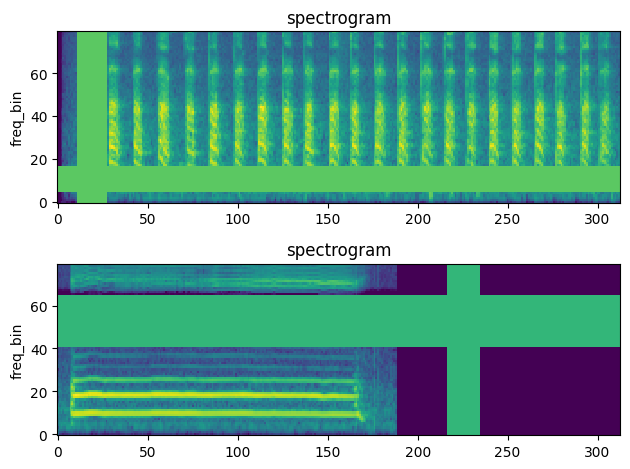

In [ ]:
import numpy as np
fig, axs = plt.subplots(2, 1)
plot_spectrogram(np.exp(inputs[0][0].cpu()), title="spectrogram", ax=axs[0])
plot_spectrogram(np.exp(inputs[1][0].cpu()), title="spectrogram", ax=axs[1])
fig.tight_layout()

/tmp/ipython-input-1648410180.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plot_spectrogram(np.exp(inputs[0][0].cpu()), title="spectrogram", ax=axs[0])
/tmp/ipython-input-1648410180.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plot_spectrogram(np.exp(inputs[1][0].cpu()), title="spectrogram", ax=axs[1])
/tmp/ipython-input-1648410180.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plot_spectrogram(np.exp(inputs2[0][0].cpu()), title="spectrogram", ax=axs[0])
/tmp/ipython-input-1648410180.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plot_spectrogram(np.exp(inputs2[1][0].cpu()), title="spectrogram", a

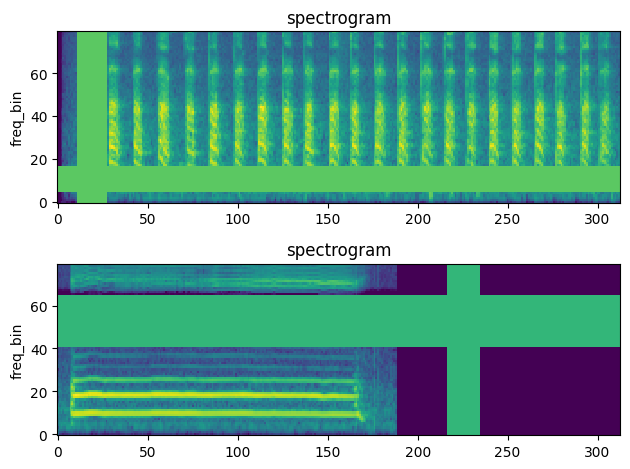

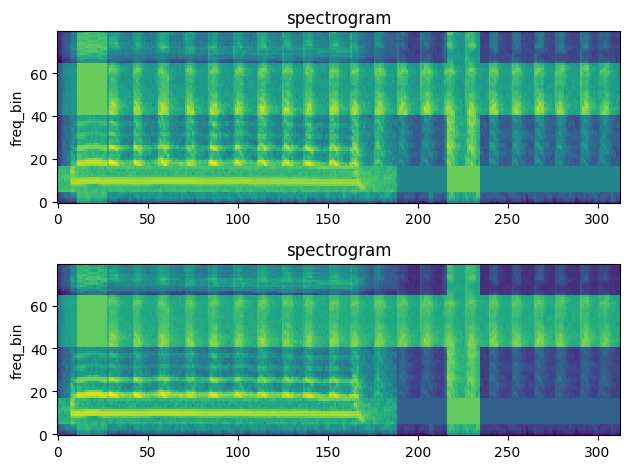

In [ ]:
from torchvision.transforms import v2

cutmix = v2.CutMix(num_classes=5)
mixup = v2.MixUp(num_classes=5, alpha=0.7)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

inputs2, targets2 = mixup(inputs, targets)

fig, axs = plt.subplots(2, 1)
plot_spectrogram(np.exp(inputs[0][0].cpu()), title="spectrogram", ax=axs[0])
plot_spectrogram(np.exp(inputs[1][0].cpu()), title="spectrogram", ax=axs[1])
fig.tight_layout()

fig, axs = plt.subplots(2, 1)
plot_spectrogram(np.exp(inputs2[0][0].cpu()), title="spectrogram", ax=axs[0])
plot_spectrogram(np.exp(inputs2[1][0].cpu()), title="spectrogram", ax=axs[1])
fig.tight_layout()

In [ ]:
targets

tensor([3, 1], device='cuda:0')

In [ ]:
targets2

tensor([[0.0000, 0.4099, 0.0000, 0.5901, 0.0000],
        [0.0000, 0.5901, 0.0000, 0.4099, 0.0000]], device='cuda:0')

/tmp/ipython-input-4067207252.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plot_spectrogram(np.exp(inputs[0][0].cpu()), title="spectrogram", ax=axs[0])
/tmp/ipython-input-4067207252.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plot_spectrogram(np.exp(inputs[1][0].cpu()), title="spectrogram", ax=axs[1])
/tmp/ipython-input-4067207252.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plot_spectrogram(np.exp(inputs2[0][0].cpu()), title="spectrogram", ax=axs[0])
/tmp/ipython-input-4067207252.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plot_spectrogram(np.exp(inputs2[1][0].cpu()), title="spectrogram", ax=a

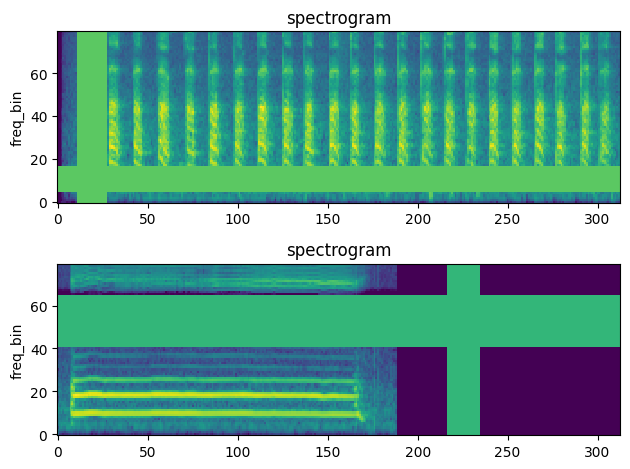

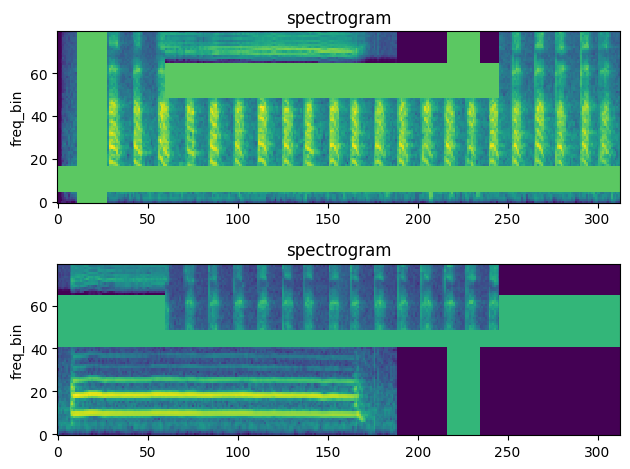

In [ ]:
inputs2, targets2 = cutmix(inputs, targets)

fig, axs = plt.subplots(2, 1)
plot_spectrogram(np.exp(inputs[0][0].cpu()), title="spectrogram", ax=axs[0])
plot_spectrogram(np.exp(inputs[1][0].cpu()), title="spectrogram", ax=axs[1])
fig.tight_layout()

fig, axs = plt.subplots(2, 1)
plot_spectrogram(np.exp(inputs2[0][0].cpu()), title="spectrogram", ax=axs[0])
plot_spectrogram(np.exp(inputs2[1][0].cpu()), title="spectrogram", ax=axs[1])
fig.tight_layout()

In [ ]:
import torchaudio.transforms as T
from torchvision.transforms import v2

time_masking = T.TimeMasking(time_mask_param=5, iid_masks=True, p=0.5)
freq_masking = T.FrequencyMasking(freq_mask_param=15, iid_masks=True)

/tmp/ipython-input-3983159943.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plot_spectrogram(np.exp(input2[0][0].cpu()), title="spectrogram", ax=axs[0])
/tmp/ipython-input-3983159943.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plot_spectrogram(np.exp(input2[1][0].cpu()), title="spectrogram", ax=axs[1])


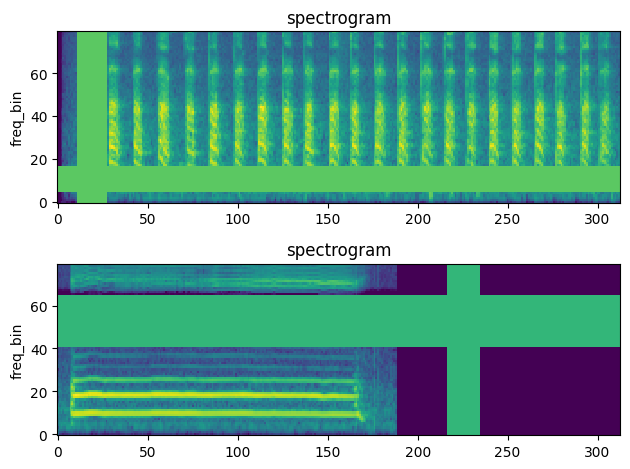

In [ ]:
input2 = time_masking(inputs)

fig, axs = plt.subplots(2, 1)
plot_spectrogram(np.exp(input2[0][0].cpu()), title="spectrogram", ax=axs[0])
plot_spectrogram(np.exp(input2[1][0].cpu()), title="spectrogram", ax=axs[1])
fig.tight_layout()

/tmp/ipython-input-3430679677.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plot_spectrogram(np.exp(input2[0][0].cpu()), title="spectrogram", ax=axs[0])
/tmp/ipython-input-3430679677.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plot_spectrogram(np.exp(input2[1][0].cpu()), title="spectrogram", ax=axs[1])


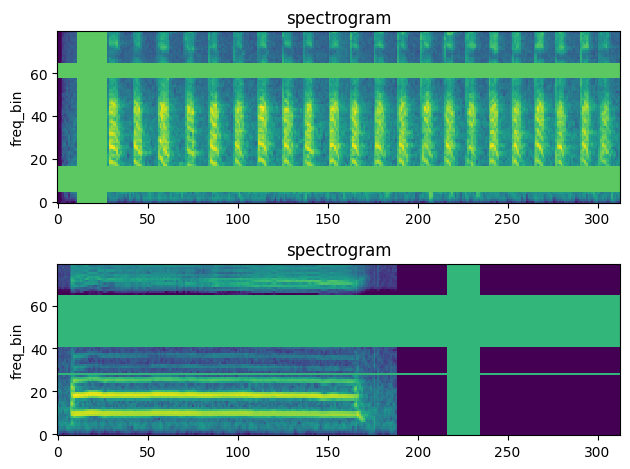

In [ ]:
input2 = freq_masking(inputs)

fig, axs = plt.subplots(2, 1)
plot_spectrogram(np.exp(input2[0][0].cpu()), title="spectrogram", ax=axs[0])
plot_spectrogram(np.exp(input2[1][0].cpu()), title="spectrogram", ax=axs[1])
fig.tight_layout()